In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm.auto import tqdm
import sys
import matplotlib
import seaborn as sns
sns.set_style("ticks", {"axes.grid": True, "grid.color": "0.95", "grid.linestyle": "-"})
pd.set_option('max_rows', 100)

# Time-of-day factor

In [9]:
## Read in all files from TAQ

# Fix forward/backslashes in directory name
taq_folder = '../data/my_data/'
if sys.platform != 'linux':
    taq_folder = taq_folder.replace('/', '\\')
print(f'Reading data from: {taq_folder}')

# Read files
taq_files = [x[2] for x in tqdm(os.walk(taq_folder))][0]
ticker_5m = pd.concat([pd.read_csv(taq_folder + taq_file) for taq_file in taq_files])

Reading data from: ..\data\my_data\


In [3]:
## Read in all files from TAQ

# Fix forward/backslashes in directory name
taq_folder = '../data/ticker_5s/'
if sys.platform != 'linux':
    taq_folder = taq_folder.replace('/', '\\')
print(f'Reading data from: {taq_folder}')

# Read files
taq_files = [x[2] for x in tqdm(os.walk(taq_folder))][0]
ticker_5s = pd.concat([pd.read_csv(taq_folder + taq_file) for taq_file in taq_files])

Reading data from: ..\data\ticker_5s\


In [4]:
#create other frequency
def re_resample_data(data,sampling_freq):
    # Fix datetime type
    data['datetime']=pd.to_datetime(data['datetime'])
    data=data.sort_values(by=["ticker", "date", "datetime"])
    
    # Resample on a given basis
    resample=(
    data.set_index("datetime")
    .groupby(["ticker", "ticker_desc", "date"])
    .resample(sampling_freq,label = 'right',closed='right')["price"]
    .last()
    .reset_index().copy()
    )
    
    # Forward fill missing prices for particular intervals using last observed price
    resample["price"] = (
    resample.sort_values(by="datetime")
    .groupby(["ticker", "ticker_desc", "date"])["price"]
    .fillna(method="ffill")
    )
    
    
    # Add returns
    resample = resample.sort_values(by=["ticker", "date", "datetime"])
    resample["log_price"] = np.log(resample["price"])
    resample["return"] = resample.groupby(["ticker", "date"])["log_price"].diff(1).fillna(0)
    
    return resample

In [5]:
ticker_1m = re_resample_data(ticker_5s,'1min')

In [7]:
ticker_1m.head(10)

,ticker,ticker_desc,date,datetime,price,log_price,return
0,AAPL,Apple,2019-09-20,2019-09-20 09:30:00,221.39,5.399926,0.000000
1,AAPL,Apple,2019-09-20,2019-09-20 09:31:00,222.15,5.403353,0.003427
2,AAPL,Apple,2019-09-20,2019-09-20 09:32:00,222.32,5.404118,0.000765
3,AAPL,Apple,2019-09-20,2019-09-20 09:33:00,222.05,5.402903,-0.001215
4,AAPL,Apple,2019-09-20,2019-09-20 09:34:00,222.07,5.402993,0.000090
5,AAPL,Apple,2019-09-20,2019-09-20 09:35:00,222.16,5.403398,0.000405
6,AAPL,Apple,2019-09-20,2019-09-20 09:36:00,221.97,5.402542,-0.000856
7,AAPL,Apple,2019-09-20,2019-09-20 09:37:00,222.14,5.403308,0.000766
8,AAPL,Apple,2019-09-20,2019-09-20 09:38:00,222.04,5.402858,-0.000450
9,AAPL,Apple,2019-09-20,2019-09-20 09:39:00,222.21,5.403623,0.000765


In [6]:
ticker_30s = re_resample_data(ticker_5s,'30s')

In [8]:
ticker_30s.head(10)

,ticker,ticker_desc,date,datetime,price,log_price,return
0,AAPL,Apple,2019-09-20,2019-09-20 09:30:00,221.39,5.399926,0.000000
1,AAPL,Apple,2019-09-20,2019-09-20 09:30:30,222.18,5.403488,0.003562
2,AAPL,Apple,2019-09-20,2019-09-20 09:31:00,222.15,5.403353,-0.000135
3,AAPL,Apple,2019-09-20,2019-09-20 09:31:30,222.44,5.404657,0.001305
4,AAPL,Apple,2019-09-20,2019-09-20 09:32:00,222.32,5.404118,-0.000540
5,AAPL,Apple,2019-09-20,2019-09-20 09:32:30,222.24,5.403758,-0.000360
6,AAPL,Apple,2019-09-20,2019-09-20 09:33:00,222.05,5.402903,-0.000855
7,AAPL,Apple,2019-09-20,2019-09-20 09:33:30,222.09,5.403083,0.000180
8,AAPL,Apple,2019-09-20,2019-09-20 09:34:00,222.07,5.402993,-0.000090
9,AAPL,Apple,2019-09-20,2019-09-20 09:34:30,222.36,5.404298,0.001305


In [10]:
#drop the first interval
def drop_first(df):
    return df.iloc[1:]

ticker_5m=ticker_5m.groupby(['ticker','date']).apply(drop_first).reset_index(drop=True)
ticker_1m=ticker_1m.groupby(['ticker','date']).apply(drop_first).reset_index(drop=True)
ticker_30s=ticker_30s.groupby(['ticker','date']).apply(drop_first).reset_index(drop=True)
ticker_5s=ticker_5s.groupby(['ticker','date']).apply(drop_first).reset_index(drop=True)

In [11]:
ticker_5m.head()

,ticker,ticker_desc,date,datetime,price,log_price,return
0,AAPL,Apple,2019-09-20,2019-09-20 09:35:00,222.160,5.403398,0.003472
1,AAPL,Apple,2019-09-20,2019-09-20 09:40:00,222.230,5.403713,0.000315
2,AAPL,Apple,2019-09-20,2019-09-20 09:45:00,221.980,5.402587,-0.001126
3,AAPL,Apple,2019-09-20,2019-09-20 09:50:00,221.680,5.401235,-0.001352
4,AAPL,Apple,2019-09-20,2019-09-20 09:55:00,221.805,5.401799,0.000564


In [12]:
ticker_1m.head()

,ticker,ticker_desc,date,datetime,price,log_price,return
0,AAPL,Apple,2019-09-20,2019-09-20 09:31:00,222.15,5.403353,0.003427
1,AAPL,Apple,2019-09-20,2019-09-20 09:32:00,222.32,5.404118,0.000765
2,AAPL,Apple,2019-09-20,2019-09-20 09:33:00,222.05,5.402903,-0.001215
3,AAPL,Apple,2019-09-20,2019-09-20 09:34:00,222.07,5.402993,0.000090
4,AAPL,Apple,2019-09-20,2019-09-20 09:35:00,222.16,5.403398,0.000405


In [13]:
def product_return(data):
    return np.abs(data[0]*data[1])

In [14]:
#set the b1=b1
ticker_5m['rr_1']=(ticker_5m.groupby(['ticker','date'])['return'].rolling(2).apply(product_return,raw=True)
                   .reset_index(drop=True).fillna(method="bfill").copy())
ticker_1m['rr_1']=(ticker_1m.groupby(['ticker','date'])['return'].rolling(2).apply(product_return,raw=True)
                   .reset_index(drop=True).fillna(method="bfill").copy())
ticker_5s['rr_1']=(ticker_5s.groupby(['ticker','date'])['return'].rolling(2).apply(product_return,raw=True)
                   .reset_index(drop=True).fillna(method="bfill").copy())
ticker_30s['rr_1']=(ticker_30s.groupby(['ticker','date'])['return'].rolling(2).apply(product_return,raw=True)
                   .reset_index(drop=True).fillna(method="bfill").copy())

In [15]:
def scale_factor(data):
    return data/np.mean(data)

def time_of_day_factor(data):
    # fix datetime type
    data['datetime'] = pd.to_datetime(data['datetime'])
    data['time'] = data['datetime'].dt.time
    df = pd.DataFrame({'bipower_factor':data.groupby(['ticker','time'])['rr_1'].mean()})
    df['time_day_factor'] = df.groupby(['ticker'])['bipower_factor'].apply(scale_factor)
    df = df.reset_index()    
    return df


In [16]:
df_5m = time_of_day_factor(ticker_5m)
df_1m = time_of_day_factor(ticker_1m)
df_30s = time_of_day_factor(ticker_30s)
df_5s = time_of_day_factor(ticker_5s)

In [17]:
#check
df_5s.groupby('ticker')['time_day_factor'].mean()

ticker
AAPL    1.0
AMZN    1.0
FB      1.0
GOOG    1.0
NFLX    1.0
Name: time_day_factor, dtype: float64

# Bipower Variance

### $BV = \frac{\pi}{2} \sum_{i=2}^{N} \mid{r_i}\mid \mid r_{i-1} \mid$

can also multiple by $\frac{N}{N-1}$
where $N=\frac{T}{\Delta_n}$

so our final estimator is $BV = \frac{N}{N-1} \times \frac{\pi}{2} \sum_{i=2}^{N} \mid{r_i}\mid \mid r_{i-1} \mid$

In [19]:
ticker_5m.head()

,ticker,ticker_desc,date,datetime,price,log_price,return,rr_1,time
0,AAPL,Apple,2019-09-20,2019-09-20 09:35:00,222.160,5.403398,0.003472,1.093811e-06,09:35:00
1,AAPL,Apple,2019-09-20,2019-09-20 09:40:00,222.230,5.403713,0.000315,1.093811e-06,09:40:00
2,AAPL,Apple,2019-09-20,2019-09-20 09:45:00,221.980,5.402587,-0.001126,3.546055e-07,09:45:00
3,AAPL,Apple,2019-09-20,2019-09-20 09:50:00,221.680,5.401235,-0.001352,1.522239e-06,09:50:00
4,AAPL,Apple,2019-09-20,2019-09-20 09:55:00,221.805,5.401799,0.000564,7.623636e-07,09:55:00


In [18]:
n_5m=len(ticker_5m.query('ticker=="AAPL" and date =="2019-09-20"'))
n_1m=len(ticker_1m.query('ticker=="AAPL" and date =="2019-09-20"'))
n_30s=len(ticker_30s.query('ticker=="AAPL" and date =="2019-09-20"'))
n_5s=len(ticker_5s.query('ticker=="AAPL" and date =="2019-09-20"'))

In [39]:
#drop the first observation and then use n/(n-1) to fix the bias
df2_5m = (ticker_5m.groupby(['ticker','date'])['rr_1'].apply(drop_first)
                   .groupby(['ticker','date']).sum()*n_5m/(n_5m-1)*np.pi/2).reset_index().rename(columns={'rr_1':'BV'})

df2_1m = (ticker_1m.groupby(['ticker','date'])['rr_1'].apply(drop_first)
                   .groupby(['ticker','date']).sum()*n_1m/(n_1m-1)*np.pi/2).reset_index().rename(columns={'rr_1':'BV'})

df2_30s = (ticker_30s.groupby(['ticker','date'])['rr_1'].apply(drop_first)
                   .groupby(['ticker','date']).sum()*n_30s/(n_30s-1)*np.pi/2).reset_index().rename(columns={'rr_1':'BV'})

df2_5s = (ticker_5s.groupby(['ticker','date'])['rr_1'].apply(drop_first)
                   .groupby(['ticker','date']).sum()*n_5s/(n_5s-1)*np.pi/2).reset_index().rename(columns={'rr_1':'BV'})




In [40]:
df2_5m.head()

,ticker,date,BV
0,AAPL,2019-09-20,0.000169
1,AAPL,2019-09-23,0.000079
2,AAPL,2019-09-24,0.000227
3,AAPL,2019-09-25,0.000062
4,AAPL,2019-09-26,0.000063


In [41]:
df2_1m.head()

,ticker,date,BV
0,AAPL,2019-09-20,0.000160
1,AAPL,2019-09-23,0.000072
2,AAPL,2019-09-24,0.000208
3,AAPL,2019-09-25,0.000106
4,AAPL,2019-09-26,0.000094


# Truncated Variance

#### Basic idea : 
- set threshold of returns, if returns beyond the threshold that this return will be regards as jump returns
- calculate variance just using continuous returns

#### Threshold:
$cut_{i,t} = \alpha\sqrt{\tau_i BV_t} \Delta_n^{0.49}$
where $\tau_i$ is the time of day factor of interval $[\Delta_{i-1},\Delta_i]$ and $BV_t$ is the bipower variance of day t

In [24]:
#time of day factor
df_5s.head()

,ticker,time,bipower_factor,time_day_factor
0,AAPL,09:30:05,1.005133e-06,17.300417
1,AAPL,09:30:10,1.005133e-06,17.300417
2,AAPL,09:30:15,6.044622e-07,10.404042
3,AAPL,09:30:20,7.693828e-07,13.242665
4,AAPL,09:30:25,7.216355e-07,12.420836


In [26]:
ticker_5s.head()

,ticker,ticker_desc,date,datetime,price,log_price,return,rr_1,time
0,AAPL,Apple,2019-09-20,2019-09-20 09:30:05,221.90,5.402227,0.002301,7.253188e-07,09:30:05
1,AAPL,Apple,2019-09-20,2019-09-20 09:30:10,221.97,5.402542,0.000315,7.253188e-07,09:30:10
2,AAPL,Apple,2019-09-20,2019-09-20 09:30:15,222.07,5.402993,0.000451,1.420278e-07,09:30:15
3,AAPL,Apple,2019-09-20,2019-09-20 09:30:20,222.20,5.403578,0.000585,2.636432e-07,09:30:20
4,AAPL,Apple,2019-09-20,2019-09-20 09:30:25,222.23,5.403713,0.000135,7.895347e-08,09:30:25


In [42]:
# merge time of day factor
data_5m = ticker_5m.merge(df_5m, how = 'left', left_on =['ticker','time'] ,right_on =['ticker','time'] )

data_1m = ticker_1m.merge(df_1m, how = 'left', left_on =['ticker','time'] ,right_on =['ticker','time'] )

data_30s = ticker_30s.merge(df_30s, how = 'left', left_on =['ticker','time'] ,right_on =['ticker','time'] )

data_5s = ticker_5s.merge(df_5s, how = 'left', left_on =['ticker','time'] ,right_on =['ticker','time'] )

In [43]:
data_1m.head()

,ticker,ticker_desc,date,datetime,price,log_price,return,rr_1,time,bipower_factor,time_day_factor
0,AAPL,Apple,2019-09-20,2019-09-20 09:31:00,222.15,5.403353,0.003427,2.621487e-06,09:31:00,0.000008,11.348810
1,AAPL,Apple,2019-09-20,2019-09-20 09:32:00,222.32,5.404118,0.000765,2.621487e-06,09:32:00,0.000008,11.348810
2,AAPL,Apple,2019-09-20,2019-09-20 09:33:00,222.05,5.402903,-0.001215,9.295774e-07,09:33:00,0.000004,6.526342
3,AAPL,Apple,2019-09-20,2019-09-20 09:34:00,222.07,5.402993,0.000090,1.094482e-07,09:34:00,0.000003,4.314291
4,AAPL,Apple,2019-09-20,2019-09-20 09:35:00,222.16,5.403398,0.000405,3.649424e-08,09:35:00,0.000002,3.194871


In [44]:
data_1m.query('ticker=="AAPL"' ).groupby('date').first()

,ticker,ticker_desc,datetime,price,log_price,return,rr_1,time,bipower_factor,time_day_factor
date,,,,,,,,,,
2019-09-20,AAPL,Apple,2019-09-20 09:31:00,222.15,5.403353,0.003427,2.621487e-06,09:31:00,0.000008,11.34881
2019-09-23,AAPL,Apple,2019-09-23 09:31:00,219.15,5.389756,0.001096,3.500528e-07,09:31:00,0.000008,11.34881
2019-09-24,AAPL,Apple,2019-09-24 09:31:00,220.81,5.397303,-0.001493,2.702832e-06,09:31:00,0.000008,11.34881
2019-09-25,AAPL,Apple,2019-09-25 09:31:00,219.30,5.390441,0.002511,2.749664e-06,09:31:00,0.000008,11.34881
2019-09-26,AAPL,Apple,2019-09-26 09:31:00,219.61,5.391853,-0.001229,1.678357e-07,09:31:00,0.000008,11.34881
...,...,...,...,...,...,...,...,...,...,...
2020-09-14,AAPL,Apple,2020-09-14 09:31:00,114.26,4.738477,-0.004105,1.043200e-05,09:31:00,0.000008,11.34881
2020-09-15,AAPL,Apple,2020-09-15 09:31:00,117.81,4.769073,-0.004489,2.667863e-06,09:31:00,0.000008,11.34881
2020-09-16,AAPL,Apple,2020-09-16 09:31:00,115.25,4.747104,0.000694,1.925336e-06,09:31:00,0.000008,11.34881


In [45]:
# merge BV
data_5m = data_5m.merge(df2_5m, how = 'left', left_on =['ticker','date'] ,right_on =['ticker','date'] )

data_1m = data_1m.merge(df2_1m, how = 'left', left_on =['ticker','date'] ,right_on =['ticker','date'] )

data_30s = data_30s.merge(df2_30s, how = 'left', left_on =['ticker','date'] ,right_on =['ticker','date'] )

data_5s = data_5s.merge(df2_5s, how = 'left', left_on =['ticker','date'] ,right_on =['ticker','date'] )

In [46]:
data_5m

,ticker,ticker_desc,date,datetime,price,log_price,return,rr_1,time,bipower_factor,time_day_factor,BV
0,AAPL,Apple,2019-09-20,2019-09-20 09:35:00,222.160,5.403398,0.003472,1.093811e-06,09:35:00,0.000013,3.884301,0.000169
1,AAPL,Apple,2019-09-20,2019-09-20 09:40:00,222.230,5.403713,0.000315,1.093811e-06,09:40:00,0.000013,3.884301,0.000169
2,AAPL,Apple,2019-09-20,2019-09-20 09:45:00,221.980,5.402587,-0.001126,3.546055e-07,09:45:00,0.000010,2.893342,0.000169
3,AAPL,Apple,2019-09-20,2019-09-20 09:50:00,221.680,5.401235,-0.001352,1.522239e-06,09:50:00,0.000007,1.928096,0.000169
4,AAPL,Apple,2019-09-20,2019-09-20 09:55:00,221.805,5.401799,0.000564,7.623636e-07,09:55:00,0.000008,2.453430,0.000169
...,...,...,...,...,...,...,...,...,...,...,...,...
98270,NFLX,Netflix,2020-09-18,2020-09-18 15:40:00,465.880,6.143928,0.000386,6.893527e-07,15:40:00,0.000004,0.708560,0.000669
98271,NFLX,Netflix,2020-09-18,2020-09-18 15:45:00,466.280,6.144786,0.000858,3.316515e-07,15:45:00,0.000003,0.659039,0.000669
98272,NFLX,Netflix,2020-09-18,2020-09-18 15:50:00,467.500,6.147399,0.002613,2.242565e-06,15:50:00,0.000004,0.720870,0.000669
98273,NFLX,Netflix,2020-09-18,2020-09-18 15:55:00,470.510,6.153817,0.006418,1.677011e-05,15:55:00,0.000006,1.067670,0.000669


In [47]:
alpha = 4 #99.99%
delta_5m = 1/n_5m
data_5m['cut'] = alpha * np.sqrt(data_5m['time_day_factor'] * data_5m['BV']) * np.power(delta_5m,0.49)

delta_1m = 1/n_1m
data_1m['cut'] = alpha * np.sqrt(data_1m['time_day_factor'] * data_1m['BV']) * np.power(delta_1m,0.49)

delta_30s = 1/n_30s
data_30s['cut'] = alpha * np.sqrt(data_30s['time_day_factor'] * data_30s['BV']) * np.power(delta_30s,0.49)

delta_5s = 1/n_5s
data_5s['cut'] = alpha * np.sqrt(data_5s['time_day_factor'] * data_5s['BV']) * np.power(delta_5s,0.49)

In [95]:
data_5m['jump'] = np.where(np.abs(data_5m['return'])>data_5m['cut'],1,0)
data_5m['rr'] = np.power(data_5m['return'],2)
data_5m['rr_c'] = data_5m['rr'] * (1-data_5m['jump'])
data_5m['rr_d'] = data_5m['rr'] * (data_5m['jump'])
data_5m['rr_c4'] = np.power(data_5m['return'],4)

data_1m['jump'] = np.where(np.abs(data_1m['return'])>data_1m['cut'],1,0)
data_1m['rr'] = np.power(data_1m['return'],2)
data_1m['rr_c'] = data_1m['rr'] * (1-data_1m['jump'])
data_1m['rr_d'] = data_1m['rr'] * (data_1m['jump'])
data_1m['rr_c4'] = np.power(data_1m['return'],4)

data_30s['jump'] = np.where(np.abs(data_30s['return'])>data_30s['cut'],1,0)
data_30s['rr'] = np.power(data_30s['return'],2)
data_30s['rr_c'] = data_30s['rr'] * (1-data_30s['jump'])
data_30s['rr_d'] = data_30s['rr'] * (data_30s['jump'])
data_30s['rr_c4'] = np.power(data_30s['return'],4)

data_5s['jump'] = np.where(np.abs(data_5s['return'])>data_5s['cut'],1,0)
data_5s['rr'] = np.power(data_5s['return'],2)
data_5s['rr_c'] = data_5s['rr'] * (1-data_5s['jump'])
data_5s['rr_d'] = data_5s['rr'] * (data_5s['jump'])
data_5s['rr_c4'] = np.power(data_5s['return'],4)

In [96]:
df3_5m = (pd.DataFrame({'TV':data_5m.groupby(['ticker','date'])['rr_c'].sum(),
                     'RV':data_5m.groupby(['ticker','date'])['rr'].sum(),
                     'BV':data_5m.groupby(['ticker','date'])['rr_1'].apply(drop_first).groupby(['ticker','date']).sum()*n_5m/(n_5m-1)*np.pi/2,
                     'Jump_num':data_5m.groupby(['ticker','date'])['jump'].sum(),
                     'Jump_s2':data_5m.groupby(['ticker','date'])['rr_d'].sum(),
                     'IQ':data_5m.groupby(['ticker','date'])['rr_c4'].sum()/3
                   
                   }).reset_index())
df3_5m['Jump_prop'] = df3_5m['Jump_s2']/df3_5m['RV']         


df3_1m = (pd.DataFrame({'TV':data_1m.groupby(['ticker','date'])['rr_c'].sum(),
                     'RV':data_1m.groupby(['ticker','date'])['rr'].sum(),
                     'BV':data_1m.groupby(['ticker','date'])['rr_1'].apply(drop_first).groupby(['ticker','date']).sum()*n_1m/(n_1m-1)*np.pi/2,
                     'Jump_num':data_1m.groupby(['ticker','date'])['jump'].sum(),
                     'Jump_s2':data_1m.groupby(['ticker','date'])['rr_d'].sum(),
                      'IQ':data_1m.groupby(['ticker','date'])['rr_c4'].sum()/3
                   
                   }).reset_index())
df3_1m['Jump_prop'] = df3_1m['Jump_s2']/df3_1m['RV']       


df3_30s = (pd.DataFrame({'TV':data_30s.groupby(['ticker','date'])['rr_c'].sum(),
                     'RV':data_30s.groupby(['ticker','date'])['rr'].sum(),
                     'BV':data_30s.groupby(['ticker','date'])['rr_1'].apply(drop_first).groupby(['ticker','date']).sum()*n_30s/(n_30s-1)*np.pi/2,
                     'Jump_num':data_30s.groupby(['ticker','date'])['jump'].sum(),
                     'Jump_s2':data_30s.groupby(['ticker','date'])['rr_d'].sum(),
                     'IQ':data_30s.groupby(['ticker','date'])['rr_c4'].sum()/3
                   
                   }).reset_index())
df3_30s['Jump_prop'] = df3_30s['Jump_s2']/df3_30s['RV']       


df3_5s = (pd.DataFrame({'TV':data_5s.groupby(['ticker','date'])['rr_c'].sum(),
                     'RV':data_5s.groupby(['ticker','date'])['rr'].sum(),
                     'BV':data_5s.groupby(['ticker','date'])['rr_1'].apply(drop_first).groupby(['ticker','date']).sum()*n_5s/(n_5s-1)*np.pi/2,
                     'Jump_num':data_5s.groupby(['ticker','date'])['jump'].sum(),
                     'Jump_s2':data_5s.groupby(['ticker','date'])['rr_d'].sum(),
                     'IQ':data_5s.groupby(['ticker','date'])['rr_c4'].sum()/3
                   
                   }).reset_index())
df3_5s['Jump_prop'] = df3_5s['Jump_s2']/df3_5s['RV']

In [97]:
#look at big jumps
df3_1m.query('Jump_prop>=0.3')

,ticker,date,TV,RV,BV,Jump_num,Jump_s2,IQ,Jump_prop
0,AAPL,2019-09-20,0.000114,0.000186,0.000160,5,0.000072,6.335456e-10,0.386515
9,AAPL,2019-10-03,0.000194,0.000295,0.000261,2,0.000101,2.741746e-09,0.341819
12,AAPL,2019-10-08,0.000127,0.000246,0.000194,3,0.000120,3.179659e-09,0.485728
14,AAPL,2019-10-10,0.000066,0.000102,0.000081,4,0.000036,1.609320e-10,0.353519
136,AAPL,2020-04-06,0.000213,0.000304,0.000261,2,0.000092,1.686587e-09,0.300926
188,AAPL,2020-06-19,0.000199,0.000316,0.000246,5,0.000117,1.583645e-09,0.371003
252,AMZN,2019-09-20,0.000092,0.000138,0.000123,4,0.000046,2.460732e-10,0.333559
266,AMZN,2019-10-10,0.000058,0.000088,0.000064,3,0.000030,1.730527e-10,0.341847
267,AMZN,2019-10-11,0.000056,0.000080,0.000070,6,0.000025,5.299708e-11,0.305745
562,FB,2019-12-12,0.000224,0.000480,0.000361,6,0.000256,1.151535e-08,0.532550


In [98]:
# mask = (data['date'] > '2020-02-01') & (data['date'] <= '2020-04-10')
# data.loc[mask].head()

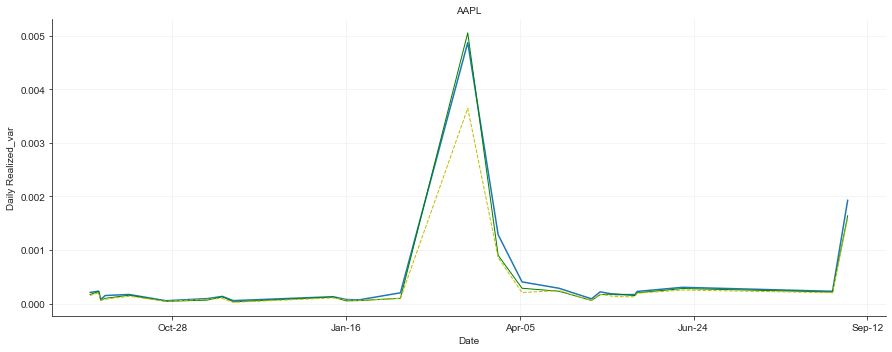

In [52]:
df3_5m['date'] = pd.to_datetime(df3_5m['date'])
g = sns.FacetGrid(df3_5m.query('ticker == "AAPL" and Jump_num >0 '), col = 'ticker', col_wrap = 1, sharex = True, aspect = 2.5, height = 5, sharey=False)
g = (g.map(plt.plot,'date', 'RV')
    .set_titles("{col_name}")
)

g = (g.map(plt.plot,'date', 'BV',color='g',ls='-', lw=1)
    .set_titles("{col_name}")
)

g = (g.map(plt.plot,'date', 'TV',color='y',ls='--',lw=1)
    .set_titles("{col_name}")
     .set_axis_labels("Date", "Daily Realized_var")
)

#
ax = g.axes.flatten()
for i in range(1):
    ax[i].xaxis.set_major_locator(plt.MaxNLocator(5))
    ax[i].xaxis.set_major_formatter(matplotlib.dates.DateFormatter("%b-%d"))
    ticker = ax[i].get_title()
    #ax[i].axvline("2020-09-16", lw=1, ls="--", color="k")
    #ax[i].axvline("2020-08-19", lw=1, ls="--", color="k")
    #ax[i].axvline("2020-09-04", lw=1, ls="--", color="k")
    

#plt.xlim(xmin='2020-01-02')
#plt.xlim(xmax='2020-09-19')
# plt.text('2020-09-01', 0.006,
#     "Something happened?",
#     ha="right",
#     va="center_baseline",
# )

# Save
plt.tight_layout()
plt.savefig("../exhibits/variance_5m.pdf", dpi=300)

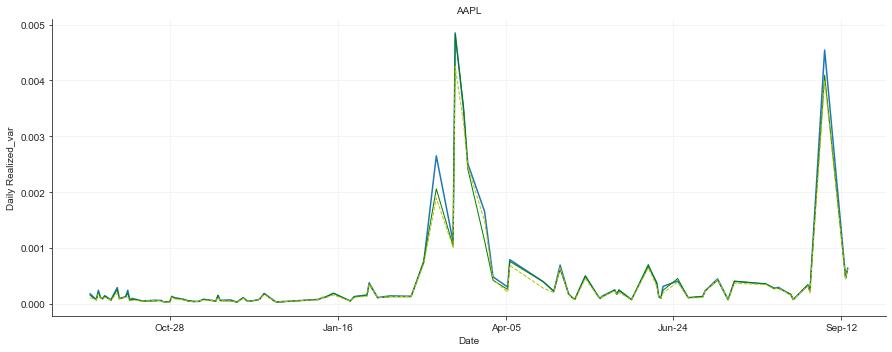

In [53]:
df3_1m['date'] = pd.to_datetime(df3_1m['date'])
g = sns.FacetGrid(df3_1m.query('ticker == "AAPL" and Jump_num >0 '), col = 'ticker', col_wrap = 1, sharex = True, aspect = 2.5, height = 5, sharey=False)
g = (g.map(plt.plot,'date', 'RV')
    .set_titles("{col_name}")
)

g = (g.map(plt.plot,'date', 'BV',color='g',ls='-', lw=1)
    .set_titles("{col_name}")
)

g = (g.map(plt.plot,'date', 'TV',color='y',ls='--',lw=1)
    .set_titles("{col_name}")
     .set_axis_labels("Date", "Daily Realized_var")
)

#
ax = g.axes.flatten()
for i in range(1):
    ax[i].xaxis.set_major_locator(plt.MaxNLocator(5))
    ax[i].xaxis.set_major_formatter(matplotlib.dates.DateFormatter("%b-%d"))
    ticker = ax[i].get_title()
    #ax[i].axvline("2020-09-16", lw=1, ls="--", color="k")
    #ax[i].axvline("2020-08-19", lw=1, ls="--", color="k")
    #ax[i].axvline("2020-09-04", lw=1, ls="--", color="k")
    

#plt.xlim(xmin='2020-01-02')
#plt.xlim(xmax='2020-09-19')
# plt.text('2020-09-01', 0.006,
#     "Something happened?",
#     ha="right",
#     va="center_baseline",
# )

# Save
plt.tight_layout()
plt.savefig("../exhibits/variance_1m.pdf", dpi=300)

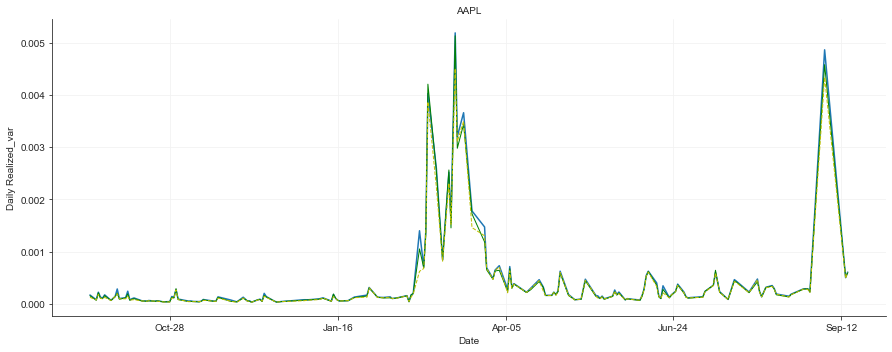

In [54]:
df3_30s['date'] = pd.to_datetime(df3_30s['date'])
g = sns.FacetGrid(df3_30s.query('ticker == "AAPL" and Jump_num >0 '), col = 'ticker', col_wrap = 1, sharex = True, aspect = 2.5, height = 5, sharey=False)
g = (g.map(plt.plot,'date', 'RV')
    .set_titles("{col_name}")
)

g = (g.map(plt.plot,'date', 'BV',color='g',ls='-', lw=1)
    .set_titles("{col_name}")
)

g = (g.map(plt.plot,'date', 'TV',color='y',ls='--',lw=1)
    .set_titles("{col_name}")
     .set_axis_labels("Date", "Daily Realized_var")
)

#
ax = g.axes.flatten()
for i in range(1):
    ax[i].xaxis.set_major_locator(plt.MaxNLocator(5))
    ax[i].xaxis.set_major_formatter(matplotlib.dates.DateFormatter("%b-%d"))
    ticker = ax[i].get_title()
    #ax[i].axvline("2020-09-16", lw=1, ls="--", color="k")
    #ax[i].axvline("2020-08-19", lw=1, ls="--", color="k")
    #ax[i].axvline("2020-09-04", lw=1, ls="--", color="k")
    

#plt.xlim(xmin='2020-01-02')
#plt.xlim(xmax='2020-09-19')
# plt.text('2020-09-01', 0.006,
#     "Something happened?",
#     ha="right",
#     va="center_baseline",
# )

# Save
plt.tight_layout()
plt.savefig("../exhibits/variance_30s.pdf", dpi=300)

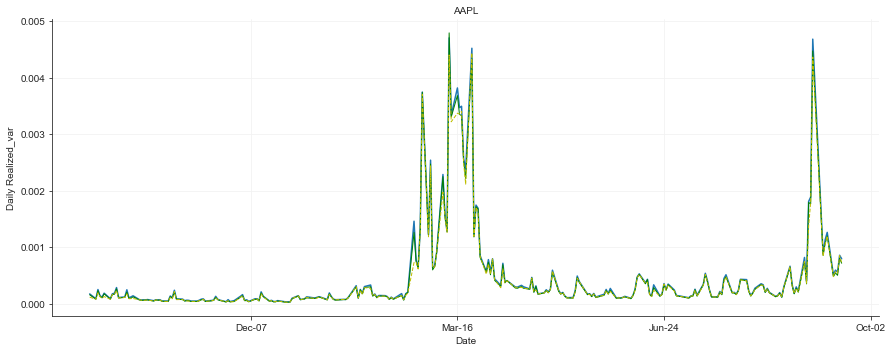

In [55]:
df3_5s['date'] = pd.to_datetime(df3_5s['date'])
g = sns.FacetGrid(df3_5s.query('ticker == "AAPL" and Jump_num >0 '), col = 'ticker', col_wrap = 1, sharex = True, aspect = 2.5, height = 5, sharey=False)
g = (g.map(plt.plot,'date', 'RV')
    .set_titles("{col_name}")
)

g = (g.map(plt.plot,'date', 'BV',color='g',ls='-', lw=1)
    .set_titles("{col_name}")
)

g = (g.map(plt.plot,'date', 'TV',color='y',ls='--',lw=1)
    .set_titles("{col_name}")
     .set_axis_labels("Date", "Daily Realized_var")
)

#
ax = g.axes.flatten()
for i in range(1):
    ax[i].xaxis.set_major_locator(plt.MaxNLocator(5))
    ax[i].xaxis.set_major_formatter(matplotlib.dates.DateFormatter("%b-%d"))
    ticker = ax[i].get_title()
    #ax[i].axvline("2020-09-16", lw=1, ls="--", color="k")
    #ax[i].axvline("2020-08-19", lw=1, ls="--", color="k")
    #ax[i].axvline("2020-09-04", lw=1, ls="--", color="k")
    

#plt.xlim(xmin='2020-01-02')
#plt.xlim(xmax='2020-09-19')
# plt.text('2020-09-01', 0.006,
#     "Something happened?",
#     ha="right",
#     va="center_baseline",
# )

# Save
plt.tight_layout()
plt.savefig("../exhibits/variance_5s.pdf", dpi=300)

In [61]:
np.std(df3_1m.query('Jump_num==1'))

TV           0.000648
RV           0.000708
BV           0.000669
Jump_num     0.000000
Jump_s2      0.000083
Jump_prop    0.052405
dtype: float64

In [62]:
df3_1m

,ticker,date,TV,RV,BV,Jump_num,Jump_s2,Jump_prop
0,AAPL,2019-09-20,0.000114,0.000186,0.000160,5,0.000072,0.386515
1,AAPL,2019-09-23,0.000073,0.000080,0.000072,2,0.000007,0.084664
2,AAPL,2019-09-24,0.000183,0.000247,0.000208,3,0.000064,0.259199
3,AAPL,2019-09-25,0.000107,0.000120,0.000106,2,0.000013,0.108020
4,AAPL,2019-09-26,0.000091,0.000094,0.000094,1,0.000003,0.028582
...,...,...,...,...,...,...,...,...
1255,NFLX,2020-09-14,0.000647,0.000647,0.000613,0,0.000000,0.000000
1256,NFLX,2020-09-15,0.000436,0.000461,0.000458,2,0.000025,0.054066
1257,NFLX,2020-09-16,0.000573,0.000573,0.000592,0,0.000000,0.000000
1258,NFLX,2020-09-17,0.000614,0.000614,0.000643,0,0.000000,0.000000


In [66]:
data_1m

,ticker,ticker_desc,date,datetime,price,log_price,return,rr_1,time,bipower_factor,time_day_factor,BV,cut,jump,rr,rr_c,rr_d
0,AAPL,Apple,2019-09-20,2019-09-20 09:31:00,222.15,5.403353,0.003427,2.621487e-06,09:31:00,7.614303e-06,11.348810,0.000160,0.009150,0,1.174417e-05,1.174417e-05,0.0
1,AAPL,Apple,2019-09-20,2019-09-20 09:32:00,222.32,5.404118,0.000765,2.621487e-06,09:32:00,7.614303e-06,11.348810,0.000160,0.009150,0,5.851578e-07,5.851578e-07,0.0
2,AAPL,Apple,2019-09-20,2019-09-20 09:33:00,222.05,5.402903,-0.001215,9.295774e-07,09:33:00,4.378745e-06,6.526342,0.000160,0.006939,0,1.476720e-06,1.476720e-06,0.0
3,AAPL,Apple,2019-09-20,2019-09-20 09:34:00,222.07,5.402993,0.000090,1.094482e-07,09:34:00,2.894605e-06,4.314291,0.000160,0.005642,0,8.111839e-09,8.111839e-09,0.0
4,AAPL,Apple,2019-09-20,2019-09-20 09:35:00,222.16,5.403398,0.000405,3.649424e-08,09:35:00,2.143547e-06,3.194871,0.000160,0.004855,0,1.641834e-07,1.641834e-07,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
491354,NFLX,Netflix,2020-09-18,2020-09-18 15:56:00,470.29,6.153350,-0.000468,1.862484e-06,15:56:00,1.655615e-06,1.583408,0.000485,0.005957,0,2.187312e-07,2.187312e-07,0.0
491355,NFLX,Netflix,2020-09-18,2020-09-18 15:57:00,469.92,6.152562,-0.000787,3.680970e-07,15:57:00,1.315424e-06,1.258053,0.000485,0.005310,0,6.194607e-07,6.194607e-07,0.0
491356,NFLX,Netflix,2020-09-18,2020-09-18 15:58:00,470.17,6.153094,0.000532,4.186079e-07,15:58:00,8.897029e-07,0.850900,0.000485,0.004367,0,2.828793e-07,2.828793e-07,0.0
491357,NFLX,Netflix,2020-09-18,2020-09-18 15:59:00,470.13,6.153009,-0.000085,4.525058e-08,15:59:00,8.731009e-07,0.835022,0.000485,0.004326,0,7.238475e-09,7.238475e-09,0.0


In [71]:
data_1m.query('jump==1')['return'].describe()

count    615.000000
mean      -0.000600
std        0.005579
min       -0.033580
25%       -0.003663
50%       -0.002029
75%        0.002746
max        0.027479
Name: return, dtype: float64

In [72]:
data_1m.query('jump==0')['return'].describe()

count    490744.000000
mean          0.000004
std           0.001275
min          -0.027315
25%          -0.000439
50%           0.000000
75%           0.000450
max           0.023945
Name: return, dtype: float64

In [74]:
data_1m.query('jump==0').groupby(['ticker'])['return'].describe()

,count,mean,std,min,25%,50%,75%,max
ticker,,,,,,,,
AAPL,98099.0,0.000005,0.001012,-0.027315,-0.000348,0.000000,0.000362,0.023945
AMZN,98130.0,0.000003,0.000926,-0.015200,-0.000353,0.000005,0.000365,0.018197
FB,98135.0,0.000004,0.001059,-0.016495,-0.000412,0.000000,0.000421,0.015058
GOOG,98213.0,0.000003,0.001876,-0.015300,-0.000675,0.000007,0.000678,0.015926
NFLX,98167.0,0.000006,0.001269,-0.018090,-0.000520,0.000000,0.000533,0.020474


In [75]:
data_1m.query('jump==1').groupby(['ticker'])['return'].describe()

,count,mean,std,min,25%,50%,75%,max
ticker,,,,,,,,
AAPL,176.0,-0.000139,0.005008,-0.023289,-0.002887,-0.001622,0.002505,0.027479
AMZN,145.0,-0.000947,0.004461,-0.012091,-0.003388,-0.002205,0.001828,0.018434
FB,136.0,-0.001373,0.006585,-0.033580,-0.004605,-0.002659,0.002998,0.021160
GOOG,47.0,0.000922,0.006888,-0.012415,-0.003706,-0.001745,0.003327,0.021771
NFLX,111.0,-0.000575,0.005701,-0.015683,-0.004200,-0.002495,0.003492,0.017781


#### Estimate $\Delta X_s^2\sigma_s^2$

- estimate spot variance : $\sigma_s^2 \approx \frac{RV_{s,s+k\Delta_n}}{k\Delta_n}$ 
 
 where $\Delta_n \to \infty$ and $k \asymp \Delta_n^{-\frac{1}{2}}$

In [99]:
k_5m = int(np.ceil(np.sqrt(n_5m)))
#calculate local var for all
data_5m['local_var'] = (data_5m.groupby(['ticker','date'])['rr_c'].rolling(k_5m,min_periods=1).mean()*n_5m).reset_index(drop=True)
data_5m['second_part'] = data_5m['local_var'] * data_5m['rr_d']
df3_5m['second_part'] = data_5m.groupby(['ticker','date'])['second_part'].sum().reset_index(drop=True)

k_1m = int(np.ceil(np.sqrt(n_1m)))
#calculate local var for all
data_1m['local_var'] = (data_1m.groupby(['ticker','date'])['rr_c'].rolling(k_1m,min_periods=1).mean()*n_1m).reset_index(drop=True)
data_1m['second_part'] = data_1m['local_var'] * data_1m['rr_d']
df3_1m['second_part'] = data_1m.groupby(['ticker','date'])['second_part'].sum().reset_index(drop=True)

k_30s = int(np.ceil(np.sqrt(n_30s)))
#calculate local var for all
data_30s['local_var'] = (data_30s.groupby(['ticker','date'])['rr_c'].rolling(k_30s,min_periods=1).mean()*n_30s).reset_index(drop=True)
data_30s['second_part'] = data_30s['local_var'] * data_30s['rr_d']
df3_30s['second_part'] = data_30s.groupby(['ticker','date'])['second_part'].sum().reset_index(drop=True)

k_5s = int(np.ceil(np.sqrt(n_5s)))
#calculate local var for all
data_5s['local_var'] = (data_5s.groupby(['ticker','date'])['rr_c'].rolling(k_5s,min_periods=1).mean()*n_5s).reset_index(drop=True)
data_5s['second_part'] = data_5s['local_var'] * data_5s['rr_d']
df3_5s['second_part'] = data_5s.groupby(['ticker','date'])['second_part'].sum().reset_index(drop=True)

In [100]:
df3_5m.head()

,ticker,date,TV,RV,BV,Jump_num,Jump_s2,IQ,Jump_prop,second_part
0,AAPL,2019-09-20,0.000152,0.000209,0.000169,1,0.000056,1.501593e-09,0.270399,2.437757e-09
1,AAPL,2019-09-23,0.000084,0.000084,0.000079,0,0.000000,2.484929e-10,0.000000,0.000000e+00
2,AAPL,2019-09-24,0.000200,0.000234,0.000227,1,0.000034,8.092886e-10,0.144826,3.529885e-09
3,AAPL,2019-09-25,0.000063,0.000077,0.000062,1,0.000014,1.282152e-10,0.184049,1.072958e-09
4,AAPL,2019-09-26,0.000075,0.000075,0.000063,0,0.000000,1.314733e-10,0.000000,0.000000e+00


In [101]:
df3_1m.head()

,ticker,date,TV,RV,BV,Jump_num,Jump_s2,IQ,Jump_prop,second_part
0,AAPL,2019-09-20,0.000114,0.000186,0.000160,5,0.000072,6.335456e-10,0.386515,8.190462e-09
1,AAPL,2019-09-23,0.000073,0.000080,0.000072,2,0.000007,3.728705e-11,0.084664,6.982008e-10
2,AAPL,2019-09-24,0.000183,0.000247,0.000208,3,0.000064,6.121102e-10,0.259199,6.559195e-09
3,AAPL,2019-09-25,0.000107,0.000120,0.000106,2,0.000013,9.440724e-11,0.108020,2.627120e-09
4,AAPL,2019-09-26,0.000091,0.000094,0.000094,1,0.000003,3.948770e-11,0.028582,4.517943e-11


In [102]:
df3_5m['second_part'] = data_5m.groupby(['ticker','date'])['second_part'].sum().reset_index(drop=True)
df3_5m['RV_var'] = 4*df3_5m['second_part'] + 2*df3_5m['IQ']
df3_5m['IV_var'] = 2*df3_5m['IQ']
df3_5m['noise_var_prop'] = 4*df3_5m['second_part'] / df3_5m['RV_var']

df3_1m['second_part'] = data_1m.groupby(['ticker','date'])['second_part'].sum().reset_index(drop=True)
df3_1m['RV_var'] = 4*df3_1m['second_part'] + 2*df3_1m['IQ']
df3_1m['IV_var'] = 2*df3_1m['IQ']
df3_1m['noise_var_prop'] = 4*df3_1m['second_part'] / df3_1m['RV_var']

df3_30s['second_part'] = data_30s.groupby(['ticker','date'])['second_part'].sum().reset_index(drop=True)
df3_30s['RV_var'] = 4*df3_30s['second_part'] + 2*df3_30s['IQ']
df3_30s['IV_var'] = 2*df3_30s['IQ']
df3_30s['noise_var_prop'] = 4*df3_30s['second_part'] / df3_30s['RV_var']

df3_5s['second_part'] = data_5s.groupby(['ticker','date'])['second_part'].sum().reset_index(drop=True)
df3_5s['RV_var'] = 4*df3_5s['second_part'] + 2*df3_5s['IQ']
df3_5s['IV_var'] = 2*df3_5s['IQ']
df3_5s['noise_var_prop'] = 4*df3_5s['second_part'] / df3_5s['RV_var']

In [103]:
df3_5m.head()

,ticker,date,TV,RV,BV,Jump_num,Jump_s2,IQ,Jump_prop,second_part,RV_var,IV_var,noise_var_prop
0,AAPL,2019-09-20,0.000152,0.000209,0.000169,1,0.000056,1.501593e-09,0.270399,2.437757e-09,1.275421e-08,3.003185e-09,0.764534
1,AAPL,2019-09-23,0.000084,0.000084,0.000079,0,0.000000,2.484929e-10,0.000000,0.000000e+00,4.969857e-10,4.969857e-10,0.000000
2,AAPL,2019-09-24,0.000200,0.000234,0.000227,1,0.000034,8.092886e-10,0.144826,3.529885e-09,1.573812e-08,1.618577e-09,0.897156
3,AAPL,2019-09-25,0.000063,0.000077,0.000062,1,0.000014,1.282152e-10,0.184049,1.072958e-09,4.548263e-09,2.564304e-10,0.943620
4,AAPL,2019-09-26,0.000075,0.000075,0.000063,0,0.000000,1.314733e-10,0.000000,0.000000e+00,2.629465e-10,2.629465e-10,0.000000


In [104]:
df3_1m.head()

,ticker,date,TV,RV,BV,Jump_num,Jump_s2,IQ,Jump_prop,second_part,RV_var,IV_var,noise_var_prop
0,AAPL,2019-09-20,0.000114,0.000186,0.000160,5,0.000072,6.335456e-10,0.386515,8.190462e-09,3.402894e-08,1.267091e-09,0.962764
1,AAPL,2019-09-23,0.000073,0.000080,0.000072,2,0.000007,3.728705e-11,0.084664,6.982008e-10,2.867377e-09,7.457410e-11,0.973992
2,AAPL,2019-09-24,0.000183,0.000247,0.000208,3,0.000064,6.121102e-10,0.259199,6.559195e-09,2.746100e-08,1.224220e-09,0.955420
3,AAPL,2019-09-25,0.000107,0.000120,0.000106,2,0.000013,9.440724e-11,0.108020,2.627120e-09,1.069729e-08,1.888145e-10,0.982349
4,AAPL,2019-09-26,0.000091,0.000094,0.000094,1,0.000003,3.948770e-11,0.028582,4.517943e-11,2.596931e-10,7.897540e-11,0.695890


In [105]:
df3_30s.head()

,ticker,date,TV,RV,BV,Jump_num,Jump_s2,IQ,Jump_prop,second_part,RV_var,IV_var,noise_var_prop
0,AAPL,2019-09-20,0.000129,0.000173,0.000159,8,0.000044,1.985152e-10,0.255212,5.501447e-09,2.240282e-08,3.970305e-10,0.982278
1,AAPL,2019-09-23,0.000077,0.000082,0.000073,1,0.000004,2.344835e-11,0.054352,6.187546e-10,2.521915e-09,4.689671e-11,0.981404
2,AAPL,2019-09-24,0.000186,0.000226,0.000217,7,0.000040,1.471726e-10,0.178740,4.896578e-09,1.988066e-08,2.943452e-10,0.985194
3,AAPL,2019-09-25,0.000109,0.000133,0.000109,5,0.000024,8.376446e-11,0.181905,5.075470e-09,2.046941e-08,1.675289e-10,0.991816
4,AAPL,2019-09-26,0.000100,0.000112,0.000107,4,0.000013,4.816064e-11,0.111682,9.625994e-10,3.946719e-09,9.632127e-11,0.975595


In [106]:
df3_5s.head()

,ticker,date,TV,RV,BV,Jump_num,Jump_s2,IQ,Jump_prop,second_part,RV_var,IV_var,noise_var_prop
0,AAPL,2019-09-20,0.000114,0.000172,0.000157,40,0.000057,6.532740e-11,0.334126,9.899262e-09,3.972770e-08,1.306548e-10,0.996711
1,AAPL,2019-09-23,0.000078,0.000086,0.000079,10,0.000008,8.682675e-12,0.088367,8.118406e-10,3.264728e-09,1.736535e-11,0.994681
2,AAPL,2019-09-24,0.000193,0.000249,0.000230,41,0.000057,6.240563e-11,0.226969,1.168930e-08,4.688203e-08,1.248113e-10,0.997338
3,AAPL,2019-09-25,0.000123,0.000140,0.000132,16,0.000017,3.265687e-11,0.121461,5.125534e-09,2.056745e-08,6.531374e-11,0.996824
4,AAPL,2019-09-26,0.000098,0.000115,0.000102,17,0.000017,1.875710e-11,0.147591,3.910294e-09,1.567869e-08,3.751419e-11,0.997607


### Code book of df3 dataframe
- IQ: the estimator of IQ, that is $\frac{1}{3}\sum {r_i^c}^2$
- second part: the estimator of $\sum \Delta X_s^2\sigma_s^2$
- RV_var: the estimator of RV variance, that is $2\widehat{IQ}+4\sum \Delta X_s^2\sigma_s^2$
- IV_var: the estimator of IV variance, that is  $2\widehat{IQ}$
- noise_var_prop : $\frac{4\sum \Delta X_s^2\sigma_s^2}{RV\_var}$
- Jump_s2 : $\sum J_i^2$
- Jump_prop : $\frac{Jump\_s2}{RV}$
- TV : $\sum {r_i^c}^2 $
- BV : $\frac{n}{n-1}\sum \mid r_i\mid \mid r_{i-1}\mid $
- RV : $\sum {r_i}^2$

where $r_i^c$ is the continouous return and n is the oberservation number of unit day